# Localizar Píxeles en Google Colab
## Métodos que SÍ funcionan en Colab

Google Colab tiene limitaciones con eventos interactivos, pero tenemos varias alternativas efectivas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import ipywidgets as widgets
from IPython.display import display, clear_output

# Cargamos imagen de ejemplo
!wget -q https://upload.wikimedia.org/wikipedia/commons/2/2f/Culinary_fruits_front_view.jpg -O frutas.jpg
imagen_bgr = cv2.imread('frutas.jpg')
imagen_rgb = imagen_bgr[:, :, [2, 1, 0]]

print(f"Imagen cargada: {imagen_rgb.shape}")

Imagen cargada: (2540, 3818, 3)


## Método 1: Imagen con ejes y grilla (FUNCIONA PERFECTO en Colab)
**La forma más confiable:** Ver coordenadas directamente en la imagen

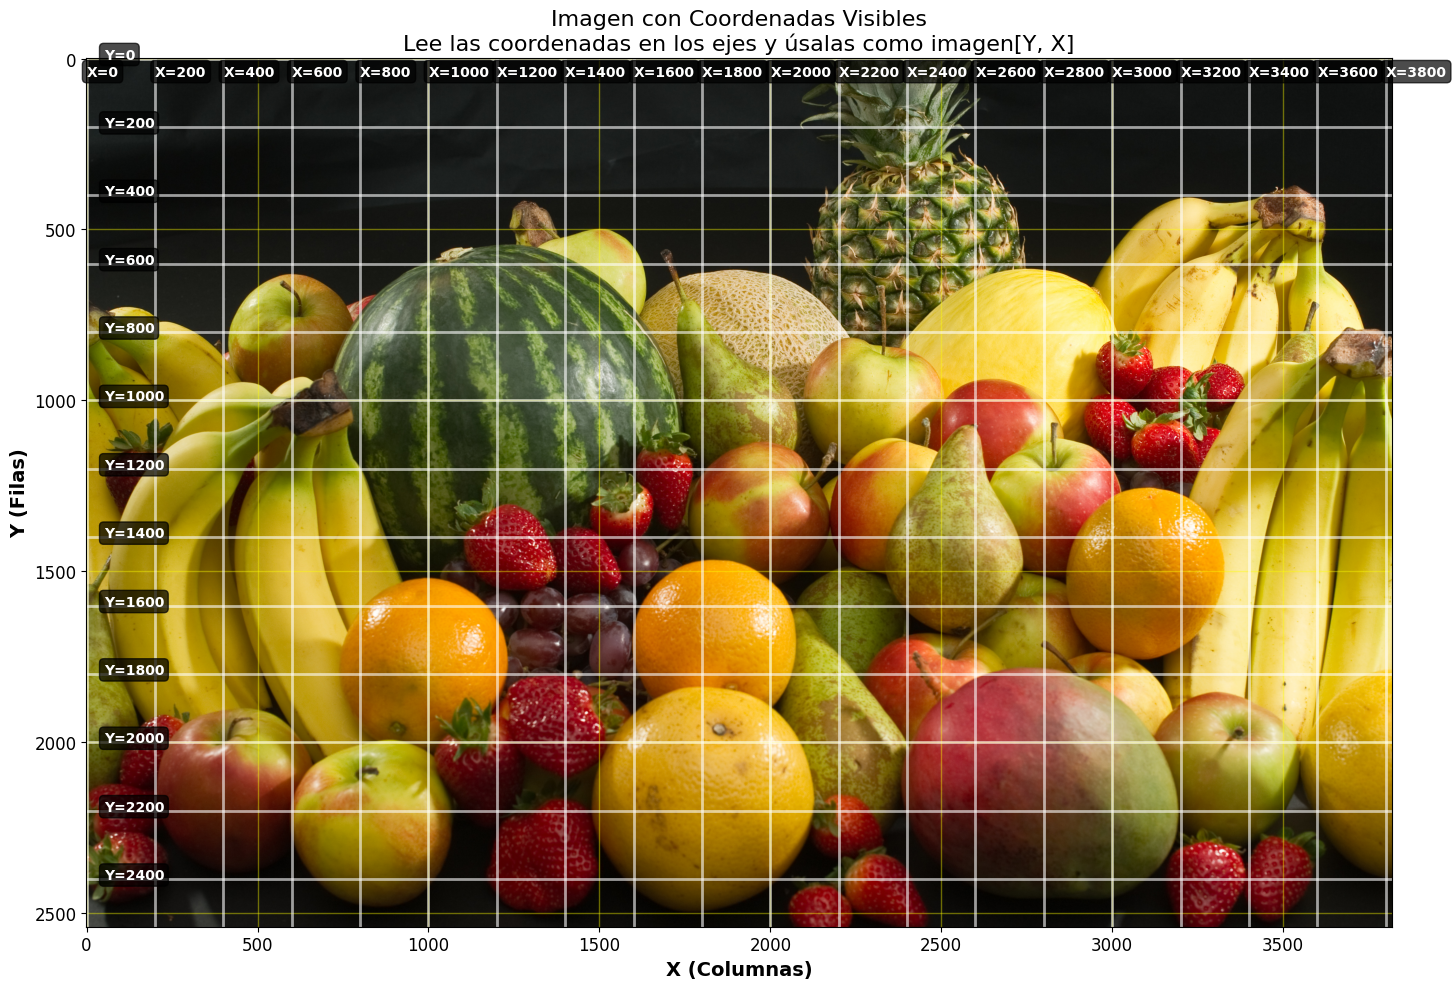

CÓMO USAR:
1. Localiza visualmente el objeto que te interesa
2. Lee las coordenadas aproximadas en los ejes
3. Usa esas coordenadas como imagen[Y, X]
4. Ajusta las coordenadas probando valores cercanos


In [2]:
def mostrar_con_coordenadas(imagen, paso_grilla=200):
    """
    Muestra imagen con coordenadas claramente visibles
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(imagen)

    # Configuramos los ejes para mostrar coordenadas
    ax.set_xlabel('X (Columnas)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Y (Filas)', fontsize=14, fontweight='bold')
    ax.set_title('Imagen con Coordenadas Visibles\nLee las coordenadas en los ejes y úsalas como imagen[Y, X]', fontsize=16)

    # Añadimos grilla para facilitar lectura
    ax.grid(True, alpha=0.4, color='yellow', linewidth=1)

    # Configuramos los ticks para que sean más legibles
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Añadimos líneas de referencia cada cierto intervalo
    for x in range(0, imagen.shape[1], paso_grilla):
        ax.axvline(x=x, color='white', alpha=0.6, linewidth=2)
        ax.text(x, 50, f'X={x}', color='white', fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))

    for y in range(0, imagen.shape[0], paso_grilla):
        ax.axhline(y=y, color='white', alpha=0.6, linewidth=2)
        ax.text(50, y, f'Y={y}', color='white', fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))

    plt.tight_layout()
    plt.show()

    print("CÓMO USAR:")
    print("1. Localiza visualmente el objeto que te interesa")
    print("2. Lee las coordenadas aproximadas en los ejes")
    print("3. Usa esas coordenadas como imagen[Y, X]")
    print("4. Ajusta las coordenadas probando valores cercanos")

mostrar_con_coordenadas(imagen_rgb)

## Método 2: Explorador interactivo con widgets (FUNCIONA en Colab)
**Alternativa interactiva:** Usar sliders para navegar por la imagen

In [3]:
def crear_explorador_widgets(imagen):
    """
    Crea un explorador interactivo usando widgets de ipywidgets
    """
    # Creamos los widgets
    x_slider = widgets.IntSlider(
        value=imagen.shape[1]//2,
        min=0,
        max=imagen.shape[1]-1,
        step=1,
        description='X (col):',
        style={'description_width': 'initial'}
    )

    y_slider = widgets.IntSlider(
        value=imagen.shape[0]//2,
        min=0,
        max=imagen.shape[0]-1,
        step=1,
        description='Y (fila):',
        style={'description_width': 'initial'}
    )

    radio_slider = widgets.IntSlider(
        value=50,
        min=20,
        max=200,
        step=10,
        description='Radio zoom:',
        style={'description_width': 'initial'}
    )

    output = widgets.Output()

    def actualizar_exploracion(x, y, radio):
        with output:
            clear_output(wait=True)

            # Obtenemos el valor del píxel
            pixel = imagen[y, x]

            # Creamos la visualización
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))

            # Imagen completa con punto marcado
            axes[0].imshow(imagen)
            axes[0].plot(x, y, 'r+', markersize=20, markeredgewidth=4)
            axes[0].set_title(f'Imagen completa\nPíxel seleccionado: ({x}, {y})')
            axes[0].grid(True, alpha=0.3)
            axes[0].set_xlabel('X (columnas)')
            axes[0].set_ylabel('Y (filas)')

            # Zoom de la región
            y_min = max(0, y - radio)
            y_max = min(imagen.shape[0], y + radio)
            x_min = max(0, x - radio)
            x_max = min(imagen.shape[1], x + radio)

            region = imagen[y_min:y_max, x_min:x_max]
            axes[1].imshow(region)

            # Marcamos el punto central en la región
            centro_x = x - x_min
            centro_y = y - y_min
            axes[1].plot(centro_x, centro_y, 'r+', markersize=15, markeredgewidth=3)

            axes[1].set_title(f'Zoom de región {region.shape[0]}x{region.shape[1]}')
            axes[1].grid(True, alpha=0.5)

            plt.tight_layout()
            plt.show()

            # Información del píxel
            print(f"INFORMACIÓN DEL PÍXEL:")
            print(f"Coordenadas: ({x}, {y}) -> usar como imagen[{y}, {x}]")
            print(f"Color RGB: R={pixel[0]}, G={pixel[1]}, B={pixel[2]}")
            print(f"Código para acceder: pixel = imagen_rgb[{y}, {x}]")

    # Conectamos los widgets
    interactive = widgets.interactive(actualizar_exploracion, x=x_slider, y=y_slider, radio=radio_slider)

    return widgets.VBox([interactive, output])

print("EXPLORADOR INTERACTIVO:")
print("Mueve los sliders para explorar diferentes píxeles de la imagen")
explorador = crear_explorador_widgets(imagen_rgb)
display(explorador)

EXPLORADOR INTERACTIVO:
Mueve los sliders para explorar diferentes píxeles de la imagen


## Método 3: Análisis por regiones predefinidas (MUY PRÁCTICO)
**Para casos comunes:** Analizar automáticamente regiones típicas donde suelen estar las frutas

ANÁLISIS DE REGIONES COMUNES:
 1. Frutillas (abajo-centro)  -> (1909, 2032) | RGB: (241, 191,  78)
 2. Frutillas (abajo-izq)     -> (1145, 2159) | RGB: ( 45,   5,   6)
 3. Frutillas (abajo-der)     -> (2672, 2159) | RGB: (103,  34,  27)
 4. Bananas (medio-der)       -> (2672,  762) | RGB: (248, 219,  89)
 5. Manzanas (centro)         -> (1909, 1270) | RGB: (168,  90,  24)
 6. Hojas (arriba-izq)        -> ( 763,  508) | RGB: ( 20,  20,  18)
 7. Fondo (esquina)           -> (  50,   50) | RGB: ( 24,  28,  27)


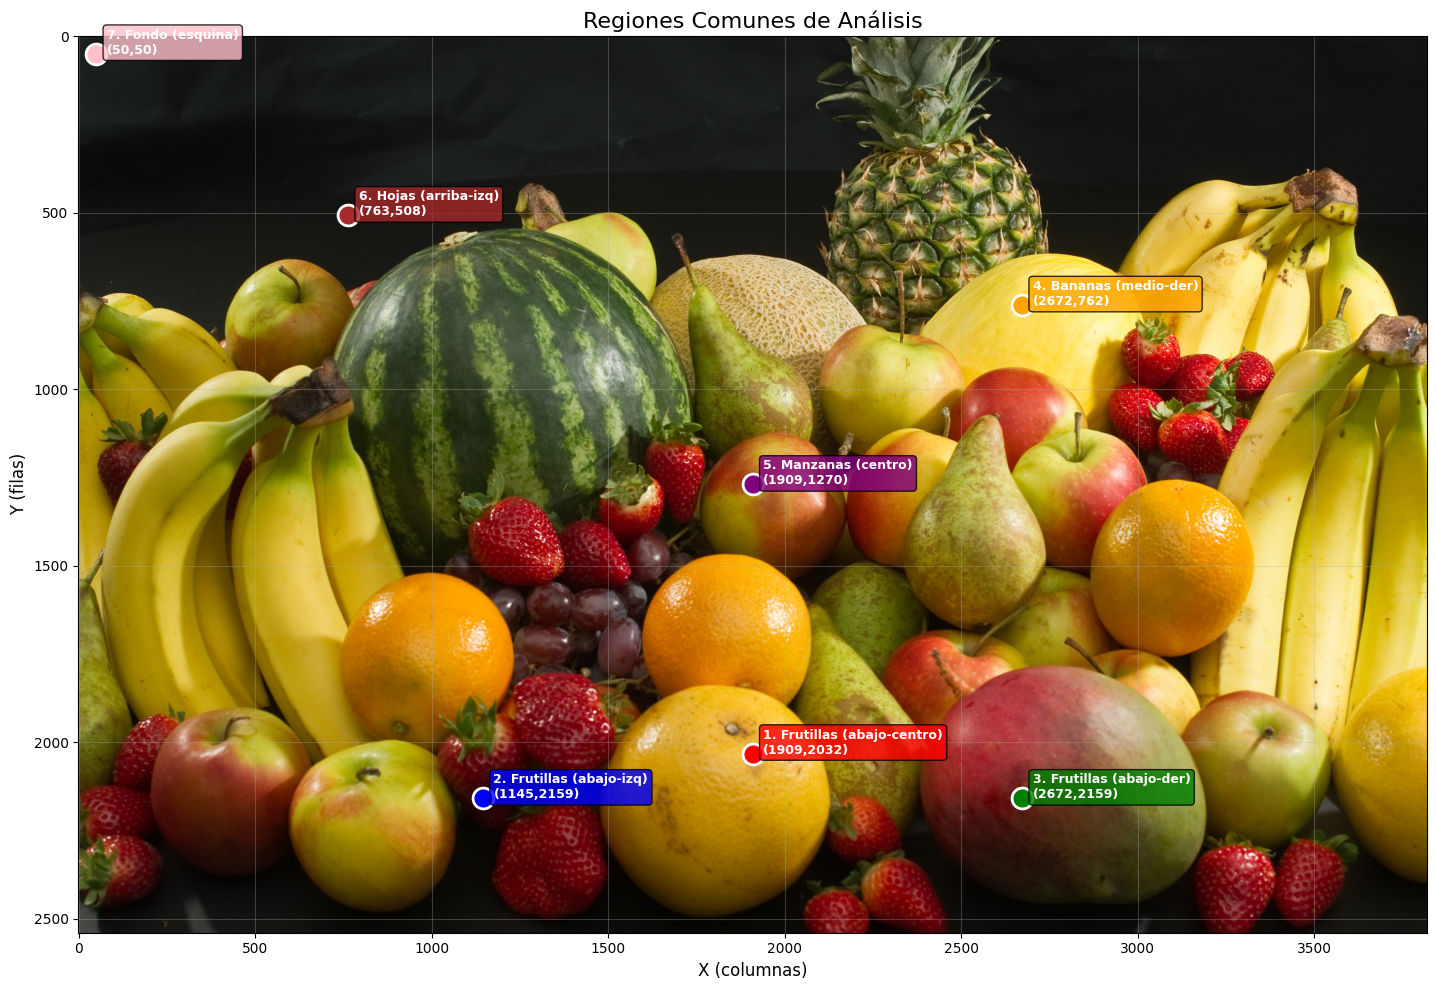

In [4]:
def analizar_regiones_comunes(imagen):
    """
    Analiza regiones típicas donde suelen encontrarse diferentes tipos de frutas
    """
    altura, anchura = imagen.shape[:2]

    # Definimos regiones típicas (ajusta según tu imagen)
    regiones = {
        'Frutillas (abajo-centro)': (anchura//2, int(altura*0.8)),
        'Frutillas (abajo-izq)': (int(anchura*0.3), int(altura*0.85)),
        'Frutillas (abajo-der)': (int(anchura*0.7), int(altura*0.85)),
        'Bananas (medio-der)': (int(anchura*0.7), int(altura*0.3)),
        'Manzanas (centro)': (anchura//2, altura//2),
        'Hojas (arriba-izq)': (int(anchura*0.2), int(altura*0.2)),
        'Fondo (esquina)': (50, 50),
    }

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(imagen)
    ax.set_title('Regiones Comunes de Análisis', fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (columnas)', fontsize=12)
    ax.set_ylabel('Y (filas)', fontsize=12)

    print("ANÁLISIS DE REGIONES COMUNES:")
    print("=" * 60)

    colores_marcadores = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
    resultados = {}

    for i, (nombre, (x, y)) in enumerate(regiones.items()):
        # Verificamos que esté dentro de los límites
        if 0 <= y < altura and 0 <= x < anchura:
            pixel = imagen[y, x]

            # Marcamos en la imagen
            color = colores_marcadores[i % len(colores_marcadores)]
            ax.plot(x, y, 'o', color=color, markersize=15, markeredgewidth=2, markeredgecolor='white')
            ax.text(x+30, y, f'{i+1}. {nombre}\n({x},{y})',
                   color='white', fontweight='bold', fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8))

            # Guardamos información
            resultados[nombre] = {
                'coordenadas': (x, y),
                'rgb': pixel,
                'codigo': f'imagen_rgb[{y}, {x}]'
            }

            print(f"{i+1:2d}. {nombre:25} -> ({x:4d}, {y:4d}) | RGB: ({pixel[0]:3d}, {pixel[1]:3d}, {pixel[2]:3d})")

    plt.tight_layout()
    plt.show()

    return resultados

resultados_regiones = analizar_regiones_comunes(imagen_rgb)

## Método 4: Búsqueda manual sistemática (SIEMPRE FUNCIONA)
**Método infalible:** Probar coordenadas manualmente de forma sistemática

Probando coordenadas específicas...
RESULTADOS DE COORDENADAS PROBADAS:
 1. Coordenadas (1200, 1900) -> RGB: ( 90,  14,   1)
 2. Coordenadas (1400, 1800) -> RGB: ( 60,  40,  29)
 3. Coordenadas (1000, 1950) -> RGB: (133,  78,   0)
 4. Coordenadas ( 800,  500) -> RGB: ( 20,  20,  18)
 5. Coordenadas ( 400,  800) -> RGB: ( 36,  35,  30)
 6. Coordenadas (1500, 1200) -> RGB: ( 37,  42,  12)
 7. Coordenadas ( 100,  100) -> RGB: ( 27,  31,  30)


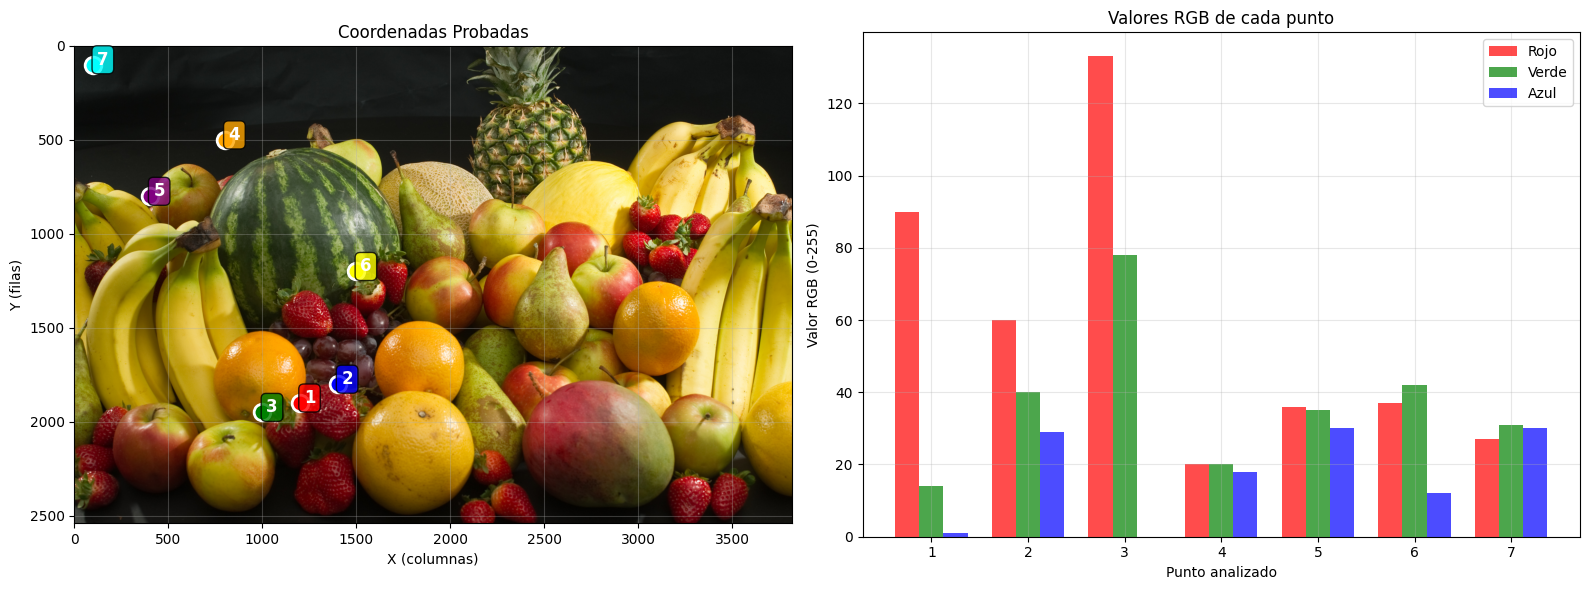

In [5]:
def probar_coordenadas_manual(imagen, lista_coordenadas):
    """
    Prueba una lista de coordenadas manualmente y muestra los resultados
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Imagen con puntos marcados
    axes[0].imshow(imagen)
    axes[0].set_title('Coordenadas Probadas')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlabel('X (columnas)')
    axes[0].set_ylabel('Y (filas)')

    # Lista de colores para diferentes puntos
    colores = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']

    print("RESULTADOS DE COORDENADAS PROBADAS:")
    print("=" * 50)

    pixeles_analizados = []

    for i, (x, y) in enumerate(lista_coordenadas):
        if 0 <= y < imagen.shape[0] and 0 <= x < imagen.shape[1]:
            pixel = imagen[y, x]
            color = colores[i % len(colores)]

            # Marcamos en la imagen
            axes[0].plot(x, y, 'o', color=color, markersize=12, markeredgewidth=2, markeredgecolor='white')
            axes[0].text(x+20, y, f'{i+1}', color='white', fontweight='bold', fontsize=12,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8))

            pixeles_analizados.append((x, y, pixel))

            print(f"{i+1:2d}. Coordenadas ({x:4d}, {y:4d}) -> RGB: ({pixel[0]:3d}, {pixel[1]:3d}, {pixel[2]:3d})")
        else:
            print(f"{i+1:2d}. Coordenadas ({x:4d}, {y:4d}) -> FUERA DE LÍMITES")

    # Gráfico de barras con valores RGB
    if pixeles_analizados:
        x_pos = range(len(pixeles_analizados))
        valores_r = [p[2][0] for p in pixeles_analizados]
        valores_g = [p[2][1] for p in pixeles_analizados]
        valores_b = [p[2][2] for p in pixeles_analizados]

        axes[1].bar([x - 0.25 for x in x_pos], valores_r, 0.25, label='Rojo', color='red', alpha=0.7)
        axes[1].bar(x_pos, valores_g, 0.25, label='Verde', color='green', alpha=0.7)
        axes[1].bar([x + 0.25 for x in x_pos], valores_b, 0.25, label='Azul', color='blue', alpha=0.7)

        axes[1].set_xlabel('Punto analizado')
        axes[1].set_ylabel('Valor RGB (0-255)')
        axes[1].set_title('Valores RGB de cada punto')
        axes[1].set_xticks(x_pos)
        axes[1].set_xticklabels([f'{i+1}' for i in range(len(pixeles_analizados))])
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return pixeles_analizados

# Ejemplo: Probamos coordenadas específicas para encontrar frutillas
# AJUSTA ESTAS COORDENADAS SEGÚN LO QUE VEAS EN LA IMAGEN
coordenadas_a_probar = [
    (1200, 1900),  # Zona de frutillas (centro-abajo)
    (1400, 1800),  # Otra frutilla
    (1000, 1950),  # Otra frutilla
    (800, 500),    # Zona de bananas
    (400, 800),    # Zona de hojas verdes
    (1500, 1200),  # Zona de manzanas rojas
    (100, 100),    # Fondo
]

print("Probando coordenadas específicas...")
pixeles_encontrados = probar_coordenadas_manual(imagen_rgb, coordenadas_a_probar)

## Método 5: Generador de código automático (PARA UMBRALES)
**Una vez que tienes coordenadas:** Genera automáticamente el código de segmentación

=== GENERANDO CÓDIGO PARA DETECTAR: FRUTILLAS ===

Analizando píxeles objetivo...
Píxel 1 en (1200, 1900): R= 90 G= 14 B=  1
Píxel 2 en (1400, 1800): R= 60 G= 40 B= 29
Píxel 3 en (1100, 1950): R= 52 G= 69 B=  1

Estadísticas RGB:
Mínimos: R= 52 G= 14 B=  1
Máximos: R= 90 G= 69 B= 29
Promedios: R= 67 G= 41 B= 10

=== CÓDIGO GENERADO PARA DETECTAR FRUTILLAS ===
# Copiar y pegar este código:


# Extraer canales de color
canal_rojo = imagen_rgb[:, :, 0]
canal_verde = imagen_rgb[:, :, 1]
canal_azul = imagen_rgb[:, :, 2]

# Umbrales para detectar frutillas
umbral_rojo_minimo = 32   # Rojo debe ser al menos 32
umbral_verde_maximo = 89  # Verde debe ser máximo 89
umbral_azul_maximo = 49   # Azul debe ser máximo 49

# Aplicar condiciones
condicion_rojo = canal_rojo >= umbral_rojo_minimo
condicion_verde = canal_verde <= umbral_verde_maximo
condicion_azul = canal_azul <= umbral_azul_maximo

# Máscara final
mascara_frutillas = condicion_rojo & condicion_verde & condicion_azul

# Aplicar máscara
im

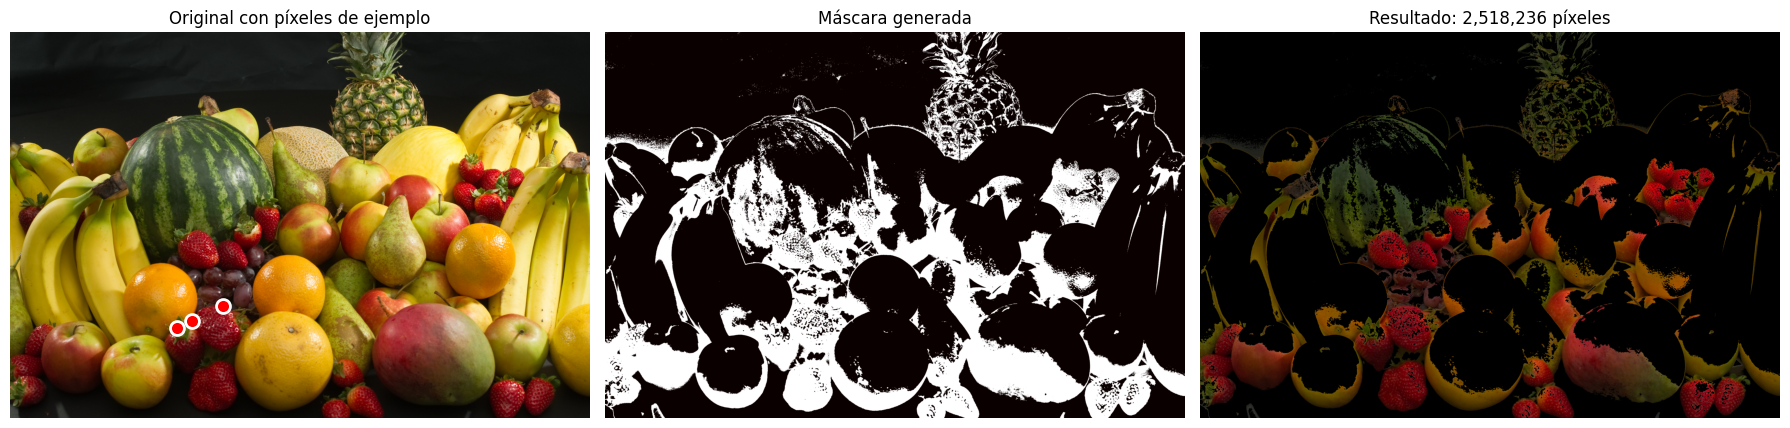


Resultado: Se detectaron 2,518,236 píxeles como frutillas


In [6]:
def generar_codigo_segmentacion(imagen, coordenadas_objetivo, nombre_objeto="objeto"):
    """
    Genera automáticamente código de segmentación basado en coordenadas de ejemplo
    """
    print(f"=== GENERANDO CÓDIGO PARA DETECTAR: {nombre_objeto.upper()} ===")
    print("\nAnalizando píxeles objetivo...")

    # Analizamos los píxeles objetivo
    valores_rgb = []
    for i, (x, y) in enumerate(coordenadas_objetivo):
        if 0 <= y < imagen.shape[0] and 0 <= x < imagen.shape[1]:
            pixel = imagen[y, x]
            valores_rgb.append(pixel)
            print(f"Píxel {i+1} en ({x:4d}, {y:4d}): R={pixel[0]:3d} G={pixel[1]:3d} B={pixel[2]:3d}")

    if not valores_rgb:
        print("ERROR: No se encontraron píxeles válidos")
        return

    valores_rgb = np.array(valores_rgb)

    # Calculamos estadísticas
    min_vals = np.min(valores_rgb, axis=0)
    max_vals = np.max(valores_rgb, axis=0)
    mean_vals = np.mean(valores_rgb, axis=0)

    print(f"\nEstadísticas RGB:")
    print(f"Mínimos: R={min_vals[0]:3.0f} G={min_vals[1]:3.0f} B={min_vals[2]:3.0f}")
    print(f"Máximos: R={max_vals[0]:3.0f} G={max_vals[1]:3.0f} B={max_vals[2]:3.0f}")
    print(f"Promedios: R={mean_vals[0]:3.0f} G={mean_vals[1]:3.0f} B={mean_vals[2]:3.0f}")

    # Sugerimos umbrales con margen de seguridad
    margen = 20
    umbral_r_min = max(0, min_vals[0] - margen)
    umbral_g_max = min(255, max_vals[1] + margen)
    umbral_b_max = min(255, max_vals[2] + margen)

    print(f"\n=== CÓDIGO GENERADO PARA DETECTAR {nombre_objeto.upper()} ===")
    print("# Copiar y pegar este código:")
    print()

    codigo = f"""
# Extraer canales de color
canal_rojo = imagen_rgb[:, :, 0]
canal_verde = imagen_rgb[:, :, 1]
canal_azul = imagen_rgb[:, :, 2]

# Umbrales para detectar {nombre_objeto}
umbral_rojo_minimo = {umbral_r_min:.0f}   # Rojo debe ser al menos {umbral_r_min:.0f}
umbral_verde_maximo = {umbral_g_max:.0f}  # Verde debe ser máximo {umbral_g_max:.0f}
umbral_azul_maximo = {umbral_b_max:.0f}   # Azul debe ser máximo {umbral_b_max:.0f}

# Aplicar condiciones
condicion_rojo = canal_rojo >= umbral_rojo_minimo
condicion_verde = canal_verde <= umbral_verde_maximo
condicion_azul = canal_azul <= umbral_azul_maximo

# Máscara final
mascara_{nombre_objeto} = condicion_rojo & condicion_verde & condicion_azul

# Aplicar máscara
imagen_solo_{nombre_objeto} = imagen_rgb.copy()
imagen_solo_{nombre_objeto}[~mascara_{nombre_objeto}] = 0

# Mostrar resultado
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(imagen_rgb)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mascara_{nombre_objeto}, cmap='gray')
plt.title('Máscara')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(imagen_solo_{nombre_objeto})
plt.title('Solo {nombre_objeto.capitalize()}')
plt.axis('off')

plt.show()
print(f'Píxeles de {nombre_objeto} detectados: {{mascara_{nombre_objeto}.sum():,}}')
"""

    print(codigo)

    # Probamos el código generado
    print("\n=== PROBANDO EL CÓDIGO GENERADO ===")

    canal_rojo = imagen[:, :, 0]
    canal_verde = imagen[:, :, 1]
    canal_azul = imagen[:, :, 2]

    condicion_rojo = canal_rojo >= umbral_r_min
    condicion_verde = canal_verde <= umbral_g_max
    condicion_azul = canal_azul <= umbral_b_max

    mascara_final = condicion_rojo & condicion_verde & condicion_azul
    pixeles_detectados = np.sum(mascara_final)

    # Visualización del resultado
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(imagen)
    # Marcamos los píxeles de ejemplo
    for x, y in coordenadas_objetivo:
        axes[0].plot(x, y, 'ro', markersize=10, markeredgewidth=2, markeredgecolor='white')
    axes[0].set_title('Original con píxeles de ejemplo')
    axes[0].axis('off')

    axes[1].imshow(mascara_final, cmap='hot')
    axes[1].set_title('Máscara generada')
    axes[1].axis('off')

    imagen_resultado = imagen.copy()
    imagen_resultado[~mascara_final] = 0
    axes[2].imshow(imagen_resultado)
    axes[2].set_title(f'Resultado: {pixeles_detectados:,} píxeles')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\nResultado: Se detectaron {pixeles_detectados:,} píxeles como {nombre_objeto}")

    return {
        'umbrales': (umbral_r_min, umbral_g_max, umbral_b_max),
        'codigo': codigo,
        'pixeles_detectados': pixeles_detectados
    }

# Ejemplo: Generamos código para detectar frutillas
# AJUSTA estas coordenadas según lo que hayas encontrado
coords_frutillas = [
    (1200, 1900),
    (1400, 1800),
    (1100, 1950)
]

resultado_codigo = generar_codigo_segmentacion(imagen_rgb, coords_frutillas, "frutillas")

## Resumen de métodos que SÍ funcionan en Colab:

### ✅ **Método 1: Imagen con ejes** - SIEMPRE funciona
- Activa `plt.axis('on')` y lee coordenadas visualmente
- **Ventaja:** Simple y confiable

### ✅ **Método 2: Widgets interactivos** - Funciona bien en Colab
- Usa sliders para explorar píxeles
- **Ventaja:** Interactivo sin problemas de compatibilidad

### ✅ **Método 3: Regiones predefinidas** - Muy práctico
- Analiza automáticamente zonas típicas
- **Ventaja:** Rápido para casos comunes

### ✅ **Método 4: Prueba manual** - Infalible
- Prueba coordenadas específicas
- **Ventaja:** Control total, siempre funciona

### ✅ **Método 5: Generador de código** - Para automatizar
- Genera código completo basado en tus coordenadas
- **Ventaja:** Ahorra tiempo de programación

### ❌ **Lo que NO funciona en Colab:**
- Eventos de mouse (clicks)
- Interactividad avanzada de matplotlib
- Callbacks de eventos del canvas

**Recomendación:** Combina el Método 1 (para exploración visual) con el Método 5 (para generar código automáticamente).